# 图像恢复

# 1. 实验介绍

## 1.1 实验背景
图像是一种非常常见的信息载体，但是在图像的获取、传输、存储的过程中可能由于各种原因使得图像受到噪声的影响。  
如何去除噪声的影响，恢复图像原本的信息是计算机视觉中的重要研究问题。

常见的图像恢复算法有基于空间域的中值滤波、基于小波域的小波去噪、基于偏微分方程的非线性扩散滤波等，在本次实验中，我们要对图像添加噪声，并对添加噪声的图像进行基于模型的去噪。

## 1.2 实验要求
A. 生成受损图像。
+ 受损图像（X）是由原始图像（$I\in R^{H*W*C}$）添加了不同噪声遮罩（noise masks）（$M\in R^{H*W*C}$）得到的（$X=I \bigodot M$），其中$\bigodot$是逐元素相乘。
+ 噪声遮罩仅包含 {0,1} 值。对原图的噪声遮罩的可以每行分别用 0.8/0.4/0.6 的噪声比率产生的，即噪声遮罩每个通道每行 80%/40%/60% 的像素值为 0，其他为 1。

B. 使用你最擅长的算法模型，进行图像恢复。

C. 评估误差为所有恢复图像（R）与原始图像（I）的 2-范数之和，此误差越小越好。$ \rm error=\sum_{i=1}^{3}norm(R_i(:)-I_i(:),2)$，其中(:)是向量化操作，其他评估方式包括 Cosine 相似度以及 SSIM 相似度。

## 1.3 实验环境
可以使用基于Python的 [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html) 库进行图像相关处理，使用 [Numpy](https://www.numpy.org/) 库进行相关数值运算。  


## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。
+ 工作目录中 `samples` 文件夹中有一些范例的原始与受损图片以供测试, 作业期间可能会补充些不同形式的受损图片


## 1.5 参考资料
OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html
    
Numpy：https://www.numpy.org/

Scikit-Learn：https://scikit-learn.org/stable/

# 2.实验部分

## 2.1 导入相关包

In [3]:
from matplotlib import pyplot as plt  # 展示图片
import numpy as np  # 数值处理
import cv2  # opencv库
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # 回归分析
from sklearn.preprocessing import PolynomialFeatures

## 2.2 读取图片

+ 读取图片我们采用 [cv2.imread(filename[, flags])](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html#display-image) 函数：
    + filename：文件路径
    + flags：指定加载图像颜色类型的标志
        + cv2.IMREAD_COLOR：读入一副彩色图像。图像的透明度会被忽略，这是默认参数，此时 flags=1。
        + cv2.IMREAD_GRAYSCALE：以灰度模式读入图像，此时 flags=0。
        + cv2.IMREAD_UNCHANGED：读入一幅图像，并且包括图像的 alpha 通道，此时 flags=-1。
        
**注意**：就算图像的路径是错的，OpenCV 也不会提醒你的，但是当你使用命令 print(img) 时得到的结果是 None。  

<br>

+ 显示图片使用 Matplotlib，具体可以参见 [Matplotlib docs](https://matplotlib.org/api/pyplot_api.html)。

**注意**：彩色图像使用 OpenCV 加载时是 BGR 模式，但是 Matplotlib 是 RGB 模式。所以彩色图像如果已经被 OpenCV 读取，那它将不会被 Matplotlib 正确显示。因此我们将 BGR模式转换为 RGB 模式即可。

<class 'numpy.ndarray'>


(-0.5, 827.5, 1103.5, -0.5)

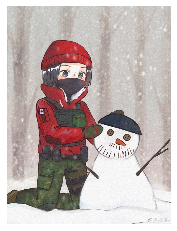

In [4]:
# 图片路径
img_path = 'A.png'

# 以 BGR 方式读取图片
img = cv2.imread(img_path)

# 将 BGR 方式转换为 RGB 方式
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 打印图片类型
print(type(img))

# 展示图片
plt.imshow(img)

# 关闭坐标轴
plt.axis('off')

读取并展示一张图片，下面我们将其封装成为一个方法。

In [5]:
def read_image(img_path):
    """
    读取图片，图片是以 np.array 类型存储
    :param img_path: 图片的路径以及名称
    :return: img np.array 类型存储
    """
    # 读取图片
    img = cv2.imread(img_path) 
    
    # 如果图片是三通道，采用 matplotlib 展示图像时需要先转换通道
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    return img

<class 'numpy.ndarray'>


(-0.5, 827.5, 1103.5, -0.5)

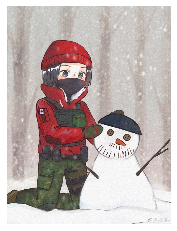

In [6]:
# 加载图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)  

# 读取图片后图片的类型
print(type(img))

# 展示图片
plt.imshow(img)  

# 关闭坐标轴
plt.axis('off') 

+ 展示图片

In [7]:
def plot_image(image, image_title, is_axis=False):
    """
    展示图像
    :param image: 展示的图像，一般是 np.array 类型
    :param image_title: 展示图像的名称
    :param is_axis: 是否需要关闭坐标轴，默认展示坐标轴
    :return:
    """
    # 展示图片
    plt.imshow(image)
    
    # 关闭坐标轴,默认关闭
    if not is_axis:
        plt.axis('off')

    # 展示受损图片的名称
    plt.title(image_title)

    # 展示图片
    plt.show()

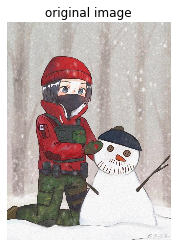

In [8]:
# 加载图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 展示图片
plot_image(image=img, image_title="original image")

## 2.3 保存图片
+ OpenCV 保存一个图片使用函数 [cv2.imwrite(filename, img[, params])](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread#cv2.imwrite)：
    + filename：保存文件路径及文件名，文件名要加格式
    + img：需要保存的图片

下面我们用 `cv2.imwrite()` 来封装一个保存图片的函数。

In [9]:
def save_image(filename, image):
    """
    将np.ndarray 图像矩阵保存为一张 png 或 jpg 等格式的图片
    :param filename: 图片保存路径及图片名称和格式
    :param image: 图像矩阵，一般为np.array
    :return:
    """
    # np.copy() 函数创建一个副本。
    # 对副本数据进行修改，不会影响到原始数据，它们物理内存不在同一位置。
    img = np.copy(image)
    
    # 从给定数组的形状中删除一维的条目
    img = img.squeeze()
    
    # 将图片数据存储类型改为 np.uint8
    if img.dtype == np.double:
        
        # 若img数据存储类型是 np.double ,则转化为 np.uint8 形式
        img = img * np.iinfo(np.uint8).max
        
        # 转换图片数组数据类型
        img = img.astype(np.uint8)
    
    # 将 RGB 方式转换为 BGR 方式
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # 生成图片
    cv2.imwrite(filename, img)

In [10]:
# 图片路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 保存图片，保存成功则文件栏会出现 A_save_img.png
save_image(filename='A_{}_img.png'.format("save"), image=img)

运行上述代码后，图片保存文件栏中。

## 2.4 归一化

+ 机器学习过程中，数据归一化非常重要，归一化的目标主要有：
    + 把数变为（0,1）或者（-1,1）之间的小数
    + 把有量纲表达式变为无量纲表达式  



+ 常见的归一化方法有:<br>
    + 线性比例变换法 $x_i = \frac{x_i}{max(x)}$
    + min-max标准化 $x_i = \frac{x_i-min(x)}{max(x)-min(x)}$
    + z-score 标准化 $x_i = \frac{x_i-mean(x)}{\sigma}$
    
    
    
+ 参考资料：
    + https://blog.csdn.net/pipisorry/article/details/52247379
    + https://blog.csdn.net/zyf89531/article/details/45922151

下面我们来实现线性比例变化法：

In [11]:
def normalization(image):
    """
    将数据线性归一化
    :param image: 图片矩阵，一般是np.array 类型 
    :return: 将归一化后的数据，在（0,1）之间
    """
    # 获取图片数据类型对象的最大值和最小值
    info = np.iinfo(image.dtype)
    
    # 图像数组数据放缩在 0-1 之间
    return image.astype(np.double) / info.max

In [12]:
# 图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 展示部分没有归一化的数据:
print("没有归一化的数据：\n", img[0, 0, :])

# 图片数据归一化
img = normalization(img)

# 展示部分 归一化后的数据
print("归一化后的数据：\n", img[0, 0, :])

没有归一化的数据：
 [186 186 184]
归一化后的数据：
 [0.72941176 0.72941176 0.72156863]


## 2.5 生成受损图像

生成受损图像的实验要求：

+ 受损图像（X）是由原始图像（$I\in R^{H*W*C}$）添加了不同噪声遮罩（noise masks）（$M\in R^{H*W*C}$）得到的（$X=I \bigodot M$），其中 $\bigodot$ 是逐元素相乘。

+ 噪声遮罩仅包含 {0,1} 值。对原图的噪声遮罩的可以每行分别用 0.8/0.4/0.6 的噪声比率产生的，即噪声遮罩每个通道每行 80%/40%/60% 的像素值为0，其他为1。


In [13]:
def noise_mask_image(img, noise_ratio):
    """
    根据题目要求生成受损图片
    :param img: 图像矩阵，一般为 np.ndarray
    :param noise_ratio: 噪声比率，可能值是0.4/0.6/0.8
    :return: noise_img 受损图片, 图像矩阵值 0-1 之间，数据类型为 np.array, 
             数据类型对象 (dtype): np.double, 图像形状:(height,width,channel),通道(channel) 顺序为RGB
    """
    # 受损图片初始化
    noise_img = np.copy(img)

    # -------------实现受损图像答题区域-----------------
    noise_mask = np.ones_like(noise_img, dtype=bool)
    noise_mask[:, :round(noise_img.shape[1] * noise_ratio), :] = False
    for channel in range(noise_img.shape[2]):
        for row in range(noise_img.shape[0]):
            np.random.shuffle(noise_mask[row, :, channel])
    noise_img = noise_img * noise_mask
    # -----------------------------------------------

    return noise_img

In [14]:
# !pip install esdk-obs-python --trusted-host pypi.org


In [15]:
# import os
# import numpy as np
# from obs import ObsClient
# # if not os.path.exists("npdata"):
# #     os.makedirs("npdata")
# # x = np.linspace(1, 100, 101)
# # np.save("npdata/x.npy",x)

# AK='IT0BUVSNXM64EU0XOGQ8'
# # AK='M58RNR4HLBFUMSOLOJCF'

# SK='j8dkml5YbEsiMZuqfs7CapoZQM5NxnumlfogeCpc'
# # SK = 'Qea1iZVG2jeimEaJ1ziMcc95lCW0QGKBxYjQiY9r'
# obs_endpoint='obs.cn-north-4.myhuaweicloud.com'
# obs_client = ObsClient(AK, SK, is_secure=True,server=obs_endpoint)

# # bucket_name = "onethousand"
# bucket_name = "dataset.kaggle.garbage"

# source_path = "./"
# target_path = "garbage/imageRestore"
# resp = obs_client.putFile(bucketName=bucket_name, objectKey=target_path, file_path=source_path)
# print(resp)

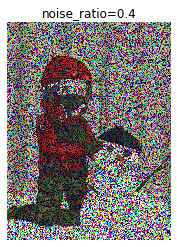

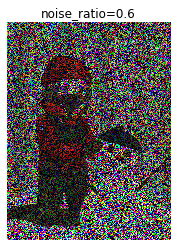

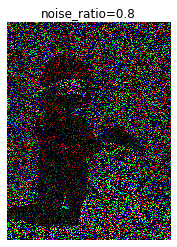

In [16]:
# 不同噪声比率产生的损失图像
noise_ratios = [0.4, 0.6, 0.8]

# 图片路径及名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 图片数据归一化
nor_img = normalization(img)

for noise_ratio in noise_ratios:
    # 生成受损图片
    noise_img = noise_mask_image(nor_img, noise_ratio)

    # 判断还未生成受损图片时，则提示对方还未生成受损图片，否则展示受损图片
    if noise_img is not None:
        # 展示受损图片
        # 图片名称
        image_title = "noise_ratio=%s" % noise_ratio
        
        # 展示图片
        plot_image(noise_img, image_title)
        
    else:
        print("返回值是 None, 请生成受损图片并返回!")
        break

## 2.6 获取损失图像

In [17]:
def get_noise_mask(noise_img):
    """
    获取噪声图像，一般为 np.array
    :param noise_img: 带有噪声的图片
    :return: 噪声图像矩阵
    """
    # 将图片数据矩阵只包含 0和1,如果不能等于 0 则就是 1。
    return np.array(noise_img != 0, dtype='double')

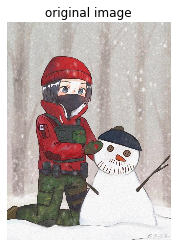

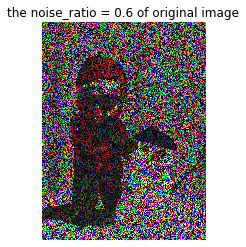

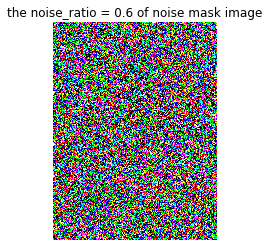

In [18]:
# 展示原始图片、受损图片、噪声图片。
# 原始图片路径
img_path = 'A.png'

# 读取图片
img = read_image(img_path)  

# 展示原始图片
plot_image(image=img, image_title="original image")

# 受损图片部分
# 图像数据归一化
nor_img = normalization(img) 

# 噪声比率
noise_ratio = 0.6

# 生成受损图片
noise_img = noise_mask_image(nor_img, noise_ratio)

if noise_img is None:
    # 未生成受损图片
    print("返回值是 None, 请生成受损图片并返回!")
    
else:
    # 展示受损图片
    plot_image(image=noise_img, image_title="the noise_ratio = %s of original image"%noise_ratio)
    
    # 根据受损图片获取噪声图片
    noise_mask = get_noise_mask(noise_img) 
    
    # 展示噪声图片
    plot_image(image=noise_mask, image_title="the noise_ratio = %s of noise mask image"%noise_ratio)


## 2.7 评估误差

评估误差为所有恢复图像（R）与原始图像（I）的2-范数之和，此误差越小越好。$ \rm error=\sum_{i=1}^{3}norm(R_i(:)-I_i(:),2)$，其中(:)是向量化操作。

理解2-范数参考资料：
+ https://blog.csdn.net/SusanZhang1231/article/details/52127011
+ https://baike.baidu.com/item/%E4%BA%8C%E8%8C%83%E6%95%B0

In [19]:
def compute_error(res_img, img):
    """
    计算恢复图像 res_img 与原始图像 img 的 2-范数
    :param res_img:恢复图像 
    :param img:原始图像 
    :return: 恢复图像 res_img 与原始图像 img 的2-范数
    """
    # 初始化
    error = 0.0
    
    # 将图像矩阵转换成为np.narray
    res_img = np.array(res_img)
    img = np.array(img)
    
    # 如果2个图像的形状不一致，则打印出错误结果，返回值为 None
    if res_img.shape != img.shape:
        print("shape error res_img.shape and img.shape %s != %s" % (res_img.shape, img.shape))
        return None
    
    # 计算图像矩阵之间的评估误差
    error = np.sqrt(np.sum(np.power(res_img - img, 2)))
    
    return round(error,3)

In [20]:
# 计算平面二维向量的 2-范数值 
img0 = [1, 0]
img1 = [0, 1]
print("平面向量的评估误差：", compute_error(img0, img1))

平面向量的评估误差： 1.414


### Cosine 相似度以及 SSIM 相似度

In [21]:
from skimage.measure import compare_ssim as ssim
from scipy import spatial

def calc_ssim(img, img_noise):
    """
    计算图片的结构相似度
    :param img: 原始图片， 数据类型为 ndarray, shape 为[长, 宽, 3]
    :param img_noise: 噪声图片或恢复后的图片，
                      数据类型为 ndarray, shape 为[长, 宽, 3]
    :return:
    """
    return ssim(img, img_noise,
                multichannel=True,
                data_range=img_noise.max() - img_noise.min())

def calc_csim(img, img_noise):
    """
    计算图片的 cos 相似度
    :param img: 原始图片， 数据类型为 ndarray, shape 为[长, 宽, 3]
    :param img_noise: 噪声图片或恢复后的图片，
                      数据类型为 ndarray, shape 为[长, 宽, 3]
    :return:
    """
    img = img.reshape(-1)
    img_noise = img_noise.reshape(-1)
    return 1 - spatial.distance.cosine(img, img_noise)

In [22]:
from PIL import Image
import numpy as np
def read_img(path):
    img = Image.open(path)
    img = img.resize((150,150))
    img = np.asarray(img, dtype="uint8")
    # 获取图片数据类型对象的最大值和最小值
    info = np.iinfo(img.dtype)
    # 图像数组数据放缩在 0-1 之间
    return img.astype(np.double) / info.max


img =  read_img('A.png')
noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1

img_noise = img + abs(noise)

print('相同图片的 SSIM 相似度: ', calc_ssim(img, img))
print('相同图片的 Cosine 相似度: ', calc_csim(img, img))
print('与噪声图片的 SSIM 相似度: ', calc_ssim(img, img_noise))
print('与噪声图片的 Cosine 相似度: ', calc_csim(img, img_noise))

相同图片的 SSIM 相似度:  1.0
相同图片的 Cosine 相似度:  1.0
与噪声图片的 SSIM 相似度:  0.9591156542707312
与噪声图片的 Cosine 相似度:  0.9977975401323774


C:\Users\56295\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


## 2.8 图像恢复

使用**你最擅长的算法模型**进行图像恢复。    

工作目录中 `samples` 文件夹中有一些范例的原始与受损图片以供测试, 作业期间可能会补充些不同形式的受损图片。


In [23]:
from multiprocessing import Process, Manager


def in_range_one(row, rows, size):
    row_beg = row - size if row - size >= 0 else 0
    row_end = row + size if row + size < rows else rows - 1
    return row_beg, row_end


def in_range_two(row, col, rows, cols, size):
    return np.array((in_range_one(row, rows, size), in_range_one(col, cols, size))).flatten()


def restore_by_mean(noise_img, size=4):
    """
    使用 你最擅长的算法模型 进行图像恢复。
    :param noise_img: 一个受损的图像
    :param size: 输入区域半径，长宽是以 size*size 方形区域获取区域, 默认是 4
    :return: res_img 恢复后的图片，图像矩阵值 0-1 之间，数据类型为 np.array,
            数据类型对象 (dtype): np.double, 图像形状:(height,width,channel), 通道(channel) 顺序为RGB
    """
    # 恢复图片初始化，首先 copy 受损图片，然后预测噪声点的坐标后作为返回值。
    res_img = np.copy(noise_img)

    # 获取噪声图像
    noise_mask = get_noise_mask(noise_img)
    # -------------实现图像恢复代码答题区域----------------------------
    rows, cols, channels = noise_img.shape
    whites = np.transpose(np.array(np.where(noise_mask == 0.)))
    for row, col, channel in whites:
        # restore_by_mean_one(row, col, rows, cols, size, channel, res_img)
        row_beg, row_end, col_beg, col_end = in_range_two(row, col, rows, cols, size)
        mean = np.sum(noise_img[row_beg:row_end, col_beg:col_end, channel])
        mean /= np.sum(noise_mask[row_beg:row_end, col_beg:col_end, channel])
        res_img[row, col, channel] = mean

    # ---------------------------------------------------------------
    return res_img


# def restore_by_mean_one(row, col, rows, cols, size, channel, res_img):
#     row_beg, row_end, col_beg, col_end = in_range_two(row, col, rows, cols, size)
#     mean = np.sum(noise_img[row_beg:row_end, col_beg:col_end, channel])
#     mean /= np.sum(noise_mask[row_beg:row_end, col_beg:col_end, channel])
#     res_img[row, col, channel] = mean


# restore image by calculating RGB means of surrounding pixels.


# restore image by quadratic linear regression
def restore_by_linear_regression(noise_img, size=4):
    # 恢复图片初始化，首先 copy 受损图片，然后预测噪声点的坐标后作为返回值。
    res_img = np.copy(noise_img)

    # 获取噪声图像
    noise_mask = get_noise_mask(noise_img)
    rows, cols, channels = noise_img.shape
    whites = np.transpose(np.array(np.where(noise_mask == 0.)))
    for row, col, channel in whites:
        # print(row, col, channel)
        # considering the boundary, and transfer the square horizontally and vertically
        row_beg, row_end, col_beg, col_end = in_range_two(row, col, rows, cols, size)
        noise_mask_local = noise_mask[row_beg:row_end, col_beg:col_end, channel]
        noise_img_local = noise_img[row_beg:row_end, col_beg:col_end, channel]
        x_train = np.transpose(np.array(np.where(noise_mask_local != 0.)))
        y_train = np.array([noise_img_local[x[0], x[1]] for x in x_train])
        if len(x_train) == 0:
            continue
        # quadratic linear regression
        quadratic = PolynomialFeatures(degree=3)
        x_train_quadratic = quadratic.fit_transform(x_train)
        regress_quadratic = LinearRegression()
        regress_quadratic.fit(x_train_quadratic, y_train)
        # predict
        test = quadratic.transform([[size, size]])
        res_img[row, col, channel] = regress_quadratic.predict(test)
    return res_img



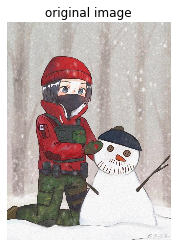

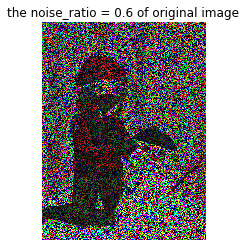

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 2 1
0 2 2
0 3 0
0 4 1
0 4 2
0 5 0
0 6 0
0 6 1
0 6 2
0 7 0
0 7 1
0 8 0
0 8 2
0 9 1
0 10 1
0 11 1
0 12 0
0 13 0
0 13 1
0 13 2
0 15 1
0 15 2
0 17 0
0 17 2
0 18 0
0 18 2
0 19 0
0 19 1
0 20 0
0 20 1
0 20 2
0 21 0
0 21 2
0 22 0
0 22 2
0 23 0
0 23 1
0 24 1
0 24 2
0 25 0
0 25 2
0 26 0
0 26 1
0 26 2
0 27 1
0 27 2
0 28 2
0 29 1
0 29 2
0 30 1
0 30 2
0 31 1
0 31 2
0 32 0
0 32 2
0 33 0
0 33 1
0 34 0
0 34 1
0 36 2
0 37 0
0 37 1
0 37 2
0 38 0
0 38 1
0 39 0
0 39 1
0 39 2
0 40 0
0 40 1
0 40 2
0 41 1
0 41 2
0 42 0
0 42 2
0 43 0
0 43 1
0 44 1
0 44 2
0 46 0
0 46 1
0 46 2
0 47 0
0 47 1
0 47 2
0 48 0
0 48 2
0 49 0
0 50 1
0 50 2
0 51 1
0 52 0
0 52 1
0 53 0
0 53 1
0 54 0
0 54 2
0 55 0
0 55 2
0 56 0
0 56 1
0 56 2
0 57 2
0 58 2
0 59 0
0 59 1
0 59 2
0 60 0
0 60 1
0 61 0
0 61 2
0 62 0
0 62 1
0 62 2
0 63 0
0 63 1
0 63 2
0 64 0
0 65 0
0 67 0
0 67 1
0 67 2
0 68 0
0 69 1
0 70 1
0 71 0
0 71 1
0 71 2
0 72 0
0 72 1
0 72 2
0 73 0
0 73 1
0 74 0
0 74 1
0 74 2
0 75 0
0 75 2
0 76 1
0 76 2
0 77

0 665 1
0 666 2
0 667 2
0 668 0
0 668 2
0 669 0
0 669 1
0 670 0
0 670 1
0 670 2
0 671 0
0 671 1
0 673 1
0 675 2
0 676 0
0 676 1
0 676 2
0 677 1
0 677 2
0 678 2
0 679 0
0 679 1
0 680 1
0 681 1
0 681 2
0 682 1
0 682 2
0 683 1
0 683 2
0 684 0
0 684 2
0 686 0
0 686 1
0 686 2
0 687 0
0 687 1
0 687 2
0 688 0
0 688 1
0 688 2
0 689 0
0 691 0
0 691 1
0 692 2
0 693 0
0 693 1
0 693 2
0 694 1
0 694 2
0 695 2
0 696 1
0 696 2
0 698 0
0 698 1
0 699 2
0 700 2
0 701 0
0 701 2
0 702 0
0 702 1
0 703 0
0 703 2
0 704 1
0 704 2
0 705 0
0 705 1
0 706 0
0 707 0
0 707 2
0 708 1
0 708 2
0 709 0
0 709 1
0 709 2
0 710 0
0 710 1
0 710 2
0 711 0
0 711 2
0 712 2
0 713 1
0 714 2
0 715 0
0 715 1
0 717 1
0 717 2
0 718 0
0 718 1
0 718 2
0 719 0
0 719 2
0 720 0
0 720 1
0 720 2
0 721 0
0 721 2
0 722 0
0 722 2
0 723 0
0 724 0
0 725 0
0 725 1
0 725 2
0 726 0
0 727 0
0 727 2
0 728 0
0 729 0
0 729 1
0 730 1
0 730 2
0 731 0
0 731 1
0 731 2
0 732 2
0 733 0
0 733 1
0 733 2
0 734 1
0 734 2
0 735 0
0 735 2
0 736 0
0 736 1
0 736 2


1 530 1
1 531 2
1 532 0
1 532 1
1 533 0
1 533 1
1 534 0
1 534 2
1 535 0
1 535 1
1 536 0
1 536 1
1 536 2
1 537 0
1 538 0
1 538 1
1 538 2
1 539 0
1 539 1
1 539 2
1 540 0
1 540 1
1 541 0
1 541 1
1 541 2
1 542 0
1 543 0
1 544 0
1 544 2
1 545 0
1 545 1
1 547 0
1 548 0
1 548 2
1 549 1
1 549 2
1 550 1
1 551 0
1 552 2
1 553 2
1 554 1
1 554 2
1 555 1
1 556 0
1 556 1
1 557 1
1 558 0
1 558 1
1 559 1
1 560 0
1 560 1
1 560 2
1 562 0
1 562 1
1 563 1
1 563 2
1 564 0
1 564 1
1 564 2
1 565 0
1 565 1
1 566 0
1 566 1
1 567 0
1 567 1
1 568 0
1 568 1
1 568 2
1 569 0
1 570 1
1 570 2
1 571 1
1 571 2
1 572 1
1 572 2
1 573 0
1 573 2
1 574 1
1 574 2
1 575 1
1 575 2
1 576 2
1 577 1
1 578 0
1 578 1
1 578 2
1 579 0
1 579 1
1 580 0
1 580 2
1 581 0
1 581 1
1 581 2
1 582 0
1 582 2
1 583 0
1 584 1
1 584 2
1 585 1
1 585 2
1 586 0
1 586 1
1 586 2
1 587 0
1 587 1
1 587 2
1 588 0
1 588 2
1 589 0
1 589 1
1 589 2
1 590 0
1 590 1
1 590 2
1 591 0
1 591 1
1 591 2
1 593 0
1 593 1
1 593 2
1 594 1
1 595 2
1 596 0
1 596 2
1 597 0


2 368 2
2 369 2
2 370 0
2 370 2
2 372 0
2 372 1
2 373 0
2 374 0
2 374 1
2 374 2
2 375 1
2 375 2
2 377 0
2 377 2
2 378 1
2 378 2
2 379 0
2 379 1
2 379 2
2 380 0
2 380 2
2 381 0
2 381 2
2 382 0
2 383 0
2 383 2
2 384 1
2 385 0
2 386 0
2 387 1
2 387 2
2 388 1
2 389 0
2 389 1
2 389 2
2 390 0
2 391 0
2 392 1
2 392 2
2 393 0
2 393 1
2 393 2
2 394 0
2 394 2
2 396 0
2 396 1
2 396 2
2 397 0
2 397 2
2 398 0
2 399 1
2 399 2
2 400 0
2 401 0
2 401 2
2 402 0
2 402 1
2 402 2
2 403 0
2 403 2
2 404 1
2 404 2
2 405 0
2 405 2
2 406 0
2 406 1
2 406 2
2 408 2
2 409 2
2 410 1
2 410 2
2 411 1
2 412 1
2 413 0
2 413 1
2 413 2
2 414 0
2 414 1
2 414 2
2 415 2
2 416 0
2 417 1
2 418 0
2 418 1
2 418 2
2 419 1
2 419 2
2 420 1
2 422 0
2 422 1
2 423 0
2 424 1
2 424 2
2 425 0
2 426 0
2 426 1
2 426 2
2 427 2
2 428 1
2 428 2
2 429 0
2 429 1
2 429 2
2 430 0
2 430 1
2 430 2
2 431 0
2 431 2
2 432 1
2 433 0
2 433 1
2 434 0
2 435 1
2 436 2
2 437 0
2 438 0
2 438 1
2 438 2
2 439 0
2 440 1
2 440 2
2 441 0
2 441 2
2 442 0
2 442 2


3 227 2
3 228 0
3 228 1
3 228 2
3 229 2
3 230 0
3 230 1
3 230 2
3 231 1
3 231 2
3 232 2
3 234 0
3 234 2
3 235 0
3 235 1
3 235 2
3 236 0
3 236 1
3 236 2
3 237 1
3 237 2
3 238 0
3 238 2
3 239 0
3 239 1
3 239 2
3 240 0
3 240 1
3 240 2
3 241 1
3 241 2
3 243 1
3 244 0
3 244 1
3 244 2
3 245 0
3 245 1
3 246 0
3 246 1
3 247 1
3 247 2
3 248 0
3 248 1
3 248 2
3 250 0
3 250 2
3 251 0
3 252 0
3 252 1
3 253 1
3 253 2
3 254 1
3 254 2
3 255 2
3 256 0
3 256 1
3 257 2
3 258 0
3 258 1
3 258 2
3 259 2
3 260 1
3 260 2
3 261 0
3 261 2
3 262 0
3 262 1
3 263 0
3 263 1
3 263 2
3 264 0
3 264 1
3 264 2
3 265 0
3 266 0
3 266 1
3 267 2
3 268 1
3 270 0
3 270 1
3 270 2
3 271 0
3 271 1
3 271 2
3 272 0
3 272 2
3 273 1
3 273 2
3 274 2
3 276 1
3 276 2
3 277 0
3 277 1
3 277 2
3 278 1
3 278 2
3 279 2
3 280 0
3 280 1
3 280 2
3 281 0
3 281 1
3 281 2
3 282 0
3 283 1
3 283 2
3 284 0
3 284 1
3 284 2
3 285 0
3 285 1
3 286 0
3 286 1
3 286 2
3 287 1
3 287 2
3 288 1
3 289 0
3 289 1
3 289 2
3 290 1
3 291 1
3 291 2
3 292 0
3 292 1


In [ ]:
# 原始图片
# 加载图片的路径和名称
img_path = 'A.png'

# 读取原始图片
img = read_image(img_path)

# 展示原始图片
plot_image(image=img, image_title="original image")

# 生成受损图片
# 图像数据归一化
nor_img = normalization(img)

# 噪声比率
noise_ratio = 0.6

# 生成受损图片
noise_img = noise_mask_image(nor_img, noise_ratio)

if noise_img is not None:
    # 展示受损图片
    plot_image(image=noise_img, image_title="the noise_ratio = %s of original image"%noise_ratio)

    # 恢复图片
    res_img = restore_by_linear_regression(noise_img)
    
    # 计算恢复图片与原始图片的误差
    print("恢复图片与原始图片的评估误差: ", compute_error(res_img, nor_img))
    print("恢复图片与原始图片的 SSIM 相似度: ", calc_ssim(res_img, nor_img))
    print("恢复图片与原始图片的 Cosine 相似度: ", calc_csim(res_img, nor_img))

    # 展示恢复图片
    plot_image(image=res_img, image_title="restore image")

    # 保存恢复图片
    save_image('res_' + img_path, res_img)
else:
    # 未生成受损图片
    print("返回值是 None, 请生成受损图片并返回!")


以上就是生成受损图片和恢复图片的全部流程，**提交作业时请注意**：

1. 请你完成生成受损图片 `noise_mask_image()` 和恢复图片 `restore_image()` 部分的代码, 请不要修改函数的输入输出！
2. 提交作业时请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 点击左侧栏`提交作业`将`noise_mask_image()`、`restore_image()`函数及导入相关包的cell转化为 py 文件后进行`系统测试`，测试通过后即可提交作业。
4. 提交作业时请记得左侧文件列表中上传『程序报告.docx』或者 『程序报告.pdf』。